# Retail Forecasting

## Problem Statement:
The large company who is into beverages business in Australia. They sell their products through various super-markets and also engage into heavy promotions throughout the year. Their demand is also influenced by various factors like holiday, seasonality. They needed forecast of each of products at item level every week in weekly buckets.

In [4]:
import numpy as np
import pandas as pd
import datetime
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [5]:
forecast = pd.read_csv('./Data/newForecast.csv')
forecast.head(3)

,Unnamed: 0,Product,date,Sales,Discount,In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,DayOfWeek,Quarter,WeekNum
0,0,SKU1,2017-02-05,27750,0.00,0,0,0,0.0,0,0,0,0,Sunday,1,5
1,1,SKU1,2017-02-12,29023,0.00,1,0,1,0.0,0,1,0,0,Sunday,1,6
2,2,SKU1,2017-02-19,45630,0.17,0,0,0,0.0,0,0,0,0,Sunday,1,7


In [6]:
forecast['date'] = pd.to_datetime(forecast['date'])

In [7]:
forecast.drop('Unnamed: 0', axis=1, inplace=True)
forecast.head(3)

,Product,date,Sales,Discount,In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,DayOfWeek,Quarter,WeekNum
0,SKU1,2017-02-05,27750,0.00,0,0,0,0.0,0,0,0,0,Sunday,1,5
1,SKU1,2017-02-12,29023,0.00,1,0,1,0.0,0,1,0,0,Sunday,1,6
2,SKU1,2017-02-19,45630,0.17,0,0,0,0.0,0,0,0,0,Sunday,1,7


In [8]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Product          1218 non-null   object        
 1   date             1218 non-null   datetime64[ns]
 2   Sales            1218 non-null   int64         
 3   Discount         1218 non-null   float64       
 4   In-Store Promo   1218 non-null   int64         
 5   Catalogue Promo  1218 non-null   int64         
 6   Store End Promo  1218 non-null   int64         
 7   Google_Mobility  1218 non-null   float64       
 8   Covid_Flag       1218 non-null   int64         
 9   V_DAY            1218 non-null   int64         
 10  EASTER           1218 non-null   int64         
 11  CHRISTMAS        1218 non-null   int64         
 12  DayOfWeek        1218 non-null   object        
 13  Quarter          1218 non-null   int64         
 14  WeekNum          1218 non-null   int64  

# Add Year and Month

In [9]:
forecast['Year'] = forecast['date'].dt.year
forecast['Month'] = forecast['date'].dt.month
forecast.head(3)

,Product,date,Sales,Discount,In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,DayOfWeek,Quarter,WeekNum,Year,Month
0,SKU1,2017-02-05,27750,0.00,0,0,0,0.0,0,0,0,0,Sunday,1,5,2017,2
1,SKU1,2017-02-12,29023,0.00,1,0,1,0.0,0,1,0,0,Sunday,1,6,2017,2
2,SKU1,2017-02-19,45630,0.17,0,0,0,0.0,0,0,0,0,Sunday,1,7,2017,2


# Modeling

In [10]:
forecast = forecast[["Product", "date","Month", "Quarter", "WeekNum", "Sales"]]
forecast.head()

,Product,date,Month,Quarter,WeekNum,Sales
0,SKU1,2017-02-05,2,1,5,27750
1,SKU1,2017-02-12,2,1,6,29023
2,SKU1,2017-02-19,2,1,7,45630
3,SKU1,2017-02-26,2,1,8,26789
4,SKU1,2017-03-05,3,1,9,41999


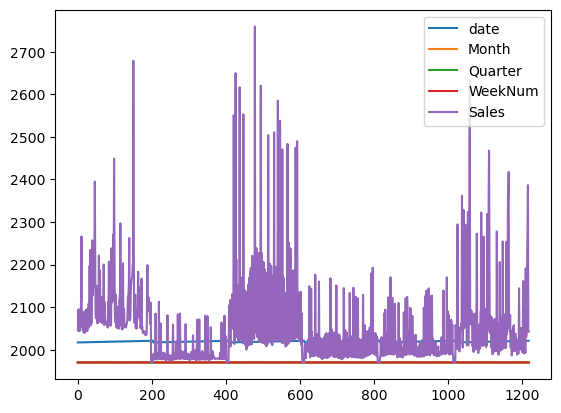

In [11]:
forecast.plot()
plt.show()

In [12]:
#Turn date column to int with a temporary df

df = forecast.copy()
df["date"] = df["date"].apply(lambda x: int(x.timestamp()))

In [13]:
#seperate by product

product1 = df[df["Product"] == "SKU1"]
product2 = df[df["Product"] == "SKU2"]
product3 = df[df["Product"] == "SKU3"]
product4 = df[df["Product"] == "SKU4"]
product5 = df[df["Product"] == "SKU5"]
product6 = df[df["Product"] == "SKU6"]

I will focus on product 1 for simplicity for now

In [14]:
#product1["date"] = product1["date"].apply(lambda x: int(x.timestamp()))


In [15]:
product1.head()

,Product,date,Month,Quarter,WeekNum,Sales
0,SKU1,1486252800,2,1,5,27750
1,SKU1,1486857600,2,1,6,29023
2,SKU1,1487462400,2,1,7,45630
3,SKU1,1488067200,2,1,8,26789
4,SKU1,1488672000,3,1,9,41999


# Linear Regression

 This is my base model. It is obviously not the best model to choose.

In [16]:
#prod = product1.copy()
X = product1[["date","Month", "Quarter", "WeekNum"]]
y = product1["Sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, random_state=42)

In [17]:
#Evaluations 
def evaluations(y_test, prediction):
    
    #mean squared error
    mse = mean_squared_error(y_test, prediction)
    
    #root mean squared error
    rmse = np.sqrt(mse)
    
    #mean absolut Error
    mae = mean_absolute_error(y_test, prediction)
    
    #Print 
    print('Mean Absolute Error: %f' % mae)
    print("Mean Squared Error: %.3f" % mse)
    print('Root Mean Squared Error: %.3f' % rmse)

In [18]:
# fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict on the same period
pred1 = lr.predict(X_test)

#Evaluations 
evaluations(y_test, pred1)

Mean Absolute Error: 17705.355757
Mean Squared Error: 639213205.012
Root Mean Squared Error: 25282.666


# GridSearch CV

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
def gridsearch(model, parameters, X_train, y_train):
    grid = GridSearchCV(estimator=model, param_grid = parameters,cv=5, n_jobs=None)
    result = grid.fit(X_train, y_train)
    
    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    

In [25]:
# Train a linear regression model using grid search and cross-validation
model = LinearRegression()
param_grid = {'fit_intercept': [True, False], 
              'positive': [True, False],
             'n_jobs': [1, 3, None]}
gridsearch(model, param_grid, X_train, y_train)

#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
#grid_search.fit(train_data[features], train_data[target])


Best Score: -0.06059452957283886
Best Hyperparameters: {'fit_intercept': True, 'n_jobs': 1, 'positive': False}


In [27]:
#USE WITH BEST PARAMETERS

# fit the model
lr = LinearRegression(fit_intercept=True, n_jobs= 1, positive= False)
lr.fit(X_train, y_train)

# predict on the same period
pred1 = lr.predict(X_test)

#Evaluations 
evaluations(y_test, pred1)

Mean Absolute Error: 17705.355757
Mean Squared Error: 639213205.012
Root Mean Squared Error: 25282.666


# Random Forest 

In [16]:
# fit the model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# predict on the same period
pred2 = rf.predict(X_test)

#Evaluations 
evaluations(y_test, pred2)

# plot what has been learned
#plt.plot(co2_data.index, co2_data.co2.values)
#plt.plot(co2_data.index, preds)

Mean Absolute Error: 11596.123000
Mean Squared Error: 285807943.500
Root Mean Squared Error: 16905.855


# GridSearchCV 

In [26]:
model = RandomForestRegressor()
param_grid = {'n_estimators': [25, 50, 100], 
              'criterion': ['squared_error', 'absolute_error'],
             'n_jobs': [None, 3, 5],
             'random_state': [42],
              'max_samples': [1,3,5]}
gridsearch(model, param_grid, X_train, y_train)

Best Score: 0.003653799922777834
Best Hyperparameters: {'criterion': 'absolute_error', 'max_samples': 5, 'n_estimators': 100, 'n_jobs': None, 'random_state': 42}


In [29]:
# fit the model
rf = RandomForestRegressor(criterion='absolute_error', max_samples= 5, n_estimators= 100, 
                           n_jobs= None, random_state= 42)
rf.fit(X_train, y_train)

# predict on the same period
pred2 = rf.predict(X_test)

#Evaluations 
evaluations(y_test, pred2)

Mean Absolute Error: 15351.275000
Mean Squared Error: 579380037.972
Root Mean Squared Error: 24070.314


# ARIMA

In [17]:
forecast = forecast[["Product", "date", "Sales"]]

In [18]:
product1 = forecast[forecast["Product"] == "SKU1"]
product2 = forecast[forecast["Product"] == "SKU2"]
product3 = forecast[forecast["Product"] == "SKU3"]
product4 = forecast[forecast["Product"] == "SKU4"]
product5 = forecast[forecast["Product"] == "SKU5"]
product6 = forecast[forecast["Product"] == "SKU6"]

In [19]:
#change forecast just to date and sales and change date into datetime
#forecast = forecast[["Product", "date", "Sales"]]

#Turn date column to object
#forecast['date'] = pd.to_datetime(forecast['date'])

forecast.head()

,Product,date,Sales
0,SKU1,2017-02-05,27750
1,SKU1,2017-02-12,29023
2,SKU1,2017-02-19,45630
3,SKU1,2017-02-26,26789
4,SKU1,2017-03-05,41999


## Stat test if it is stationary or not  using Augmented Dickey-Fuller Test

In [20]:
# ADF Test
# Function to print out results in customised manner
def adf_test(df):
    
    df.index = df['date']

    # Check the data type
    del df['date']
    del df["Product"]
    # View the dataset
    #df.head()
    
    timeseries = df["Sales"]
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [21]:
#product 1
adf_test(product1)

Results of Dickey-Fuller Test:
Test Statistic                -8.709707e+00
p-value                        3.618957e-14
#Lags Used                     0.000000e+00
Number of Observations Used    2.030000e+02
Critical Value (1%)           -3.462980e+00
Critical Value (5%)           -2.875885e+00
Critical Value (10%)          -2.574416e+00
dtype: float64


In [22]:
# Product 2
adf_test(product2)

Results of Dickey-Fuller Test:
Test Statistic                -1.510105e+01
p-value                        7.939761e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.030000e+02
Critical Value (1%)           -3.462980e+00
Critical Value (5%)           -2.875885e+00
Critical Value (10%)          -2.574416e+00
dtype: float64


In [23]:
# Product 3
adf_test(product3)

Results of Dickey-Fuller Test:
Test Statistic                -5.752370e+00
p-value                        5.925780e-07
#Lags Used                     3.000000e+00
Number of Observations Used    2.000000e+02
Critical Value (1%)           -3.463476e+00
Critical Value (5%)           -2.876102e+00
Critical Value (10%)          -2.574532e+00
dtype: float64


In [24]:
# Product 4
adf_test(product4)

Results of Dickey-Fuller Test:
Test Statistic                  -5.589760
p-value                          0.000001
#Lags Used                       3.000000
Number of Observations Used    200.000000
Critical Value (1%)             -3.463476
Critical Value (5%)             -2.876102
Critical Value (10%)            -2.574532
dtype: float64


In [25]:
# Product 5
adf_test(product5)

Results of Dickey-Fuller Test:
Test Statistic                  -4.407753
p-value                          0.000288
#Lags Used                       4.000000
Number of Observations Used    199.000000
Critical Value (1%)             -3.463645
Critical Value (5%)             -2.876176
Critical Value (10%)            -2.574572
dtype: float64


In [26]:
# Product 6
adf_test(product6)

Results of Dickey-Fuller Test:
Test Statistic                  -5.259048
p-value                          0.000007
#Lags Used                       3.000000
Number of Observations Used    194.000000
Critical Value (1%)             -3.464515
Critical Value (5%)             -2.876556
Critical Value (10%)            -2.574775
dtype: float64


## All of the products are stationary based on the Augmented Dickey-Fuller Test.

## ARIMA Model

In [27]:
#Train/test split
#X = product1.values
#size = int(len(X) * 0.60)
#X_train, X_test = X[0:size], X[size:len(X)]
X_train, X_test = train_test_split(product1.values, train_size=0.66, random_state=42)

history = [x for x in X_train]
pred3 = list()


# walk-forward validation
for x in range(len(X_test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    pred3.append(yhat)
    obs = X_test[x]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))


predicted=36706.111447, expected=25936.000000
predicted=40601.118769, expected=54655.000000
predicted=36500.749410, expected=119393.000000
predicted=54796.180359, expected=32373.000000
predicted=70234.596286, expected=52964.000000
predicted=52087.293649, expected=94633.000000
predicted=66605.753378, expected=33665.000000
predicted=70855.283468, expected=36955.000000
predicted=51889.041644, expected=0.000000
predicted=43941.007019, expected=23891.000000
predicted=27445.980870, expected=49314.000000
predicted=27941.205990, expected=77842.000000
predicted=38949.748603, expected=39290.000000
predicted=47229.993539, expected=41141.000000
predicted=43791.476733, expected=51305.000000
predicted=49096.961411, expected=55980.000000
predicted=51620.699792, expected=43689.000000
predicted=49484.109491, expected=31850.000000
predicted=44795.713035, expected=33908.000000
predicted=41039.737595, expected=72587.000000
predicted=44325.538949, expected=26410.000000
predicted=48326.188707, expected=8043

In [28]:
#predicted=995.744348, expected=0.000000
#predicted=995.744348, expected=0.000000
# evaluate forecasts

#Forecast Error (or Residual Forecast Error)
forecast_errors = [X_test[i]-pred3[i] for i in range(len(X_test))]

#forecast bias
bias =  np.mean(forecast_errors)


#Print 
#print('Forecast Errors: %s' % forecast_errors)
print('Forecasting Bias or Mean Forecast Error: %f' % bias)
#Evaluations 
evaluations(X_test, pred3)


Forecasting Bias or Mean Forecast Error: 107.421563
Mean Absolute Error: 21247.458148
Mean Squared Error: 889640825.835
Root Mean Squared Error: 29826.847


Based on the <b>forecasting bias</b> the model is under forecasting. 

Based on the <b>Mean Absolute Error</b>, it is really high. The closer to 0 the better the model can be. 

The model has a high <b>Mean Squared Error</b>. A mean squared error of zero indicates perfect skill, or no error.

The model has a high <b>Root Mean Squared Error</b>.As with the mean squared error, an RMSE of zero indicates no error.

In [29]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  203
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2377.254
Date:                Wed, 13 Sep 2023   AIC                           4766.508
Time:                        10:26:49   BIC                           4786.357
Sample:                             0   HQIC                          4774.539
                                - 203                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8625      0.081    -10.715      0.000      -1.020      -0.705
ar.L2         -0.5277      0.117     -4.496      0.000      -0.758      -0.298
ar.L3         -0.4179      0.121     -3.446      0.0

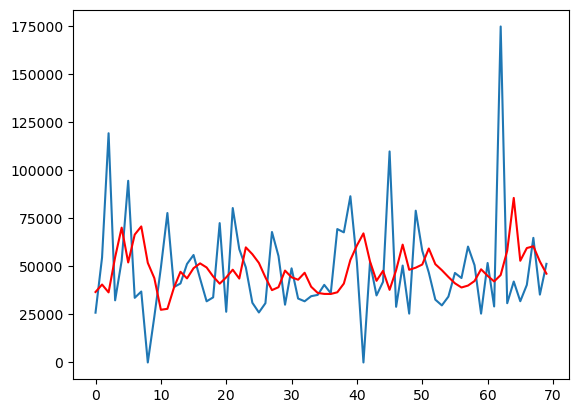

In [30]:
# plot forecasts against actual outcomes
plt.plot(X_test)
plt.plot(pred3, color='red')
plt.show()

# ARMA

# Autoregression (AR)

# Moving Average (MA)

# Seasonal Autoregressive Integrated Moving-Average (SARIMA)